[[이유한님] 캐글 코리아 캐글 스터디 커널 커리큘럼](https://kaggle-kr.tistory.com/32)

[TensorFlow Speech Recognition Challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge)

[Speech representation and data exploration](https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration)

In [1]:
import os
import zipfile
import py7zr
import warnings
warnings.filterwarnings("ignore")

# dir_path = './input/006_tensorflow-speech-recognition-challenge/'

# fp_zip = "./input/tensorflow-speech-recognition-challenge.zip"
# with zipfile.ZipFile(fp_zip, "r") as f:
#     f.extractall(dir_path)

# from glob import glob
# fp_7zs = glob("./input/006_tensorflow-speech-recognition-challenge/*.7z")
# for file in glob("./input/006_tensorflow-speech-recognition-challenge/*.7z"):
#     with py7zr.SevenZipFile(file, 'r') as f:
#         f.extractall(dir_path)

# [os.remove(f) for f in fp_7zs + [fp_zip]];

Introduction
Hello! This is my very first Kernel. It is meant to give a grasp of a problem of speech representation. I'd also like to take a look on a features specific to this dataset.

Content:

- 1. Visualization of the recordings - input features
  - 1.1. Wave and spectrogram
  - 1.2. MFCC
  - 1.3. Sprectrogram in 3d
  - 1.4. Silence removal
  - 1.5. Resampling - dimensionality reductions
  - 1.6. Features extraction steps
- 2. Dataset investigation
  - 2.1. Number of files
  - 2.2. Mean spectrograms and fft
  - 2.3. Deeper into recordings
  - 2.4. Length of recordings
  - 2.5. Note on Gaussian Mixtures modeling
  - 2.6. Frequency components across the words
  - 2.7. Anomaly detection
- 3. Where to look for the inspiration

All we need is here:

In [2]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

#Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
# import librosa
"pip install librosa"

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

# %matplotlib
get_ipython().run_line_magic('matplotlib', 'inline')    # 매직명렁어 안 될 때

# 1. Visualization

There are two theories of a human hearing - place ( https://en.wikipedia.org/wiki/Place_theory_(hearing) (frequency-based) and temporal (https://en.wikipedia.org/wiki/Temporal_theory_(hearing) ) In speech recognition, I see two main tendencies - to input [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) (frequencies), and more sophisticated features MFCC - Mel-Frequency Cepstral Coefficients, PLP. You rarely work with raw, temporal data.

Let's visualize some recordings!

# DeepL 번역

인간의 청각에는 장소( https://en.wikipedia.org/wiki/Place_theory_(청각)(주파수 기반)와 시간적(https://en.wikipedia.org/wiki/Temporal_theory_(청각))이라는 두 가지 이론이 있습니다. 음성 인식에서는 [스펙트로그램](https://en.wikipedia.org/wiki/Spectrogram)(주파수)과 보다 정교한 기능인 MFCC(멜-주파수 세프랙 계수, PLP)를 입력하는 두 가지 주요 경향을 볼 수 있습니다. 원시, 시간적 데이터로 작업하는 경우는 거의 없습니다.
녹음을 시각화해 봅시다!

## 1.1. Wave and spectrogram:

Choose and read some file:

In [3]:
# train_audio_path = '../input/train/audio/'
train_audio_path = './input/006_tensorflow-speech-recognition-challenge/train/audio/'
filename = "./yes/0a7c2a8d_nohash_0.wav"
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

Define a function that calculates spectrogram.

Note, that we are taking logarithm of spectrogram values. It will make our plot much more clear, moreover, it is strictly connected to the way people hear. We need to assure that there are no 0 values as input to logarithm.

In [4]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window="hann",
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Frequencies are in range (0, 8000) according to [Nyquist theorem](https://en.wikipedia.org/wiki/Nyquist_rate).

Let's plot it:

Text(0.5, 0, 'Seconds')

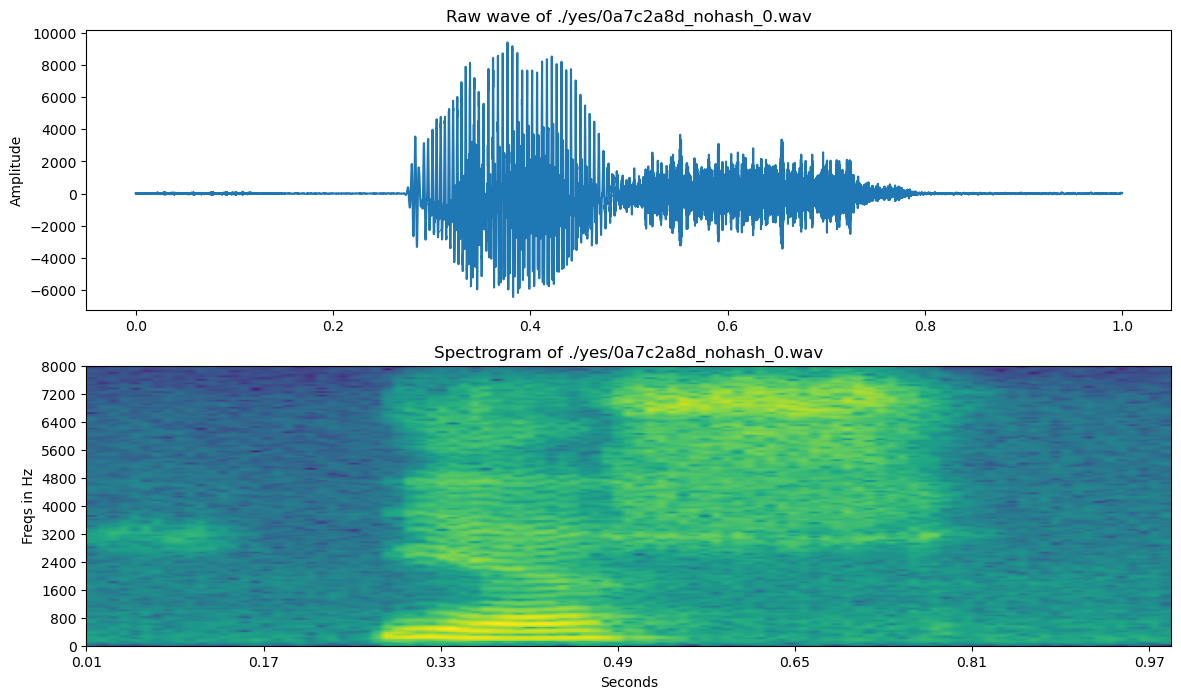

In [5]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(211)
ax1.set_title("Raw wave of " + filename)
ax1.set_ylabel("Amplitude")
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect="auto", origin="lower",
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title("Spectrogram of " + filename)
ax2.set_ylabel("Freqs in Hz")
ax2.set_xlabel("Seconds")

If we use spectrogram as an input features for NN, we have to remember to normalize features. (We need to normalize over all the dataset, here's example just for one, which doesn't give good mean and std!)

In [6]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

There is an interesting fact to point out. We have ~160 features for each frame, frequencies are between 0 and 8000. It means, that one feature corresponds to 50 Hz. However, [frequency resolution of the ear is 3.6 Hz within the octave of 1000 – 2000 Hz](https://en.wikipedia.org/wiki/Psychoacoustics) It means, that people are far more precise and can hear much smaller details than those represented by spectrograms like above.

**DeepL 번역**  
한 가지 흥미로운 사실을 지적할 수 있습니다. 각 프레임당 약 160개의 피처가 있으며 주파수는 0에서 8000 사이입니다. 즉, 하나의 피처는 50Hz에 해당합니다. 그러나 [귀의 주파수 분해능은 1000~2000Hz의 옥타브 내에서 3.6Hz](https://en.wikipedia.org/wiki/Psychoacoustics) 입니다. 즉, 사람들은 위와 같은 스펙트로그램으로 표현되는 것보다 훨씬 더 정밀하고 훨씬 작은 디테일까지 들을 수 있다는 뜻입니다.

## 1.2. MFCC

If you want to get to know some details about MFCC take a look at this great tutorial. [MFCC explained](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/) You can see, that it is well prepared to imitate human hearing properties.

You can calculate Mel power spectrogram and MFCC using for example librosa python package.

## DeepL 번역

MFCC에 대해 자세히 알고 싶으시다면 이 튜토리얼을 참조하세요. [MFCC 설명](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/) 사람의 청각 특성을 모방할 수 있도록 잘 준비되어 있음을 알 수 있습니다.
예를 들어 라이브러사 파이썬 패키지를 사용하여 멜 파워 스펙트로그램과 MFCC를 계산할 수 있습니다.

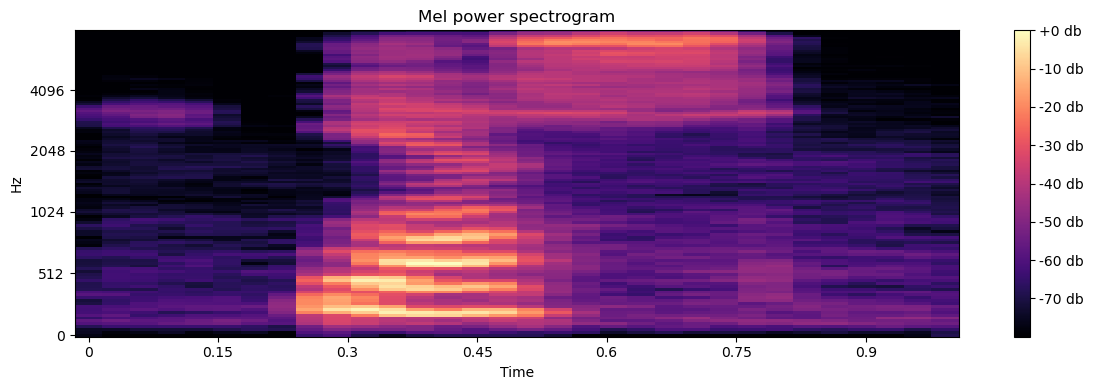

In [7]:
# from this tutorial
# https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
# S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)
samples = samples.astype(np.float32)  # float여야만 함
S = librosa.feature.melspectrogram(y=samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title("Mel power spectrogram")
plt.colorbar(format="%+02.f db")
plt.tight_layout()

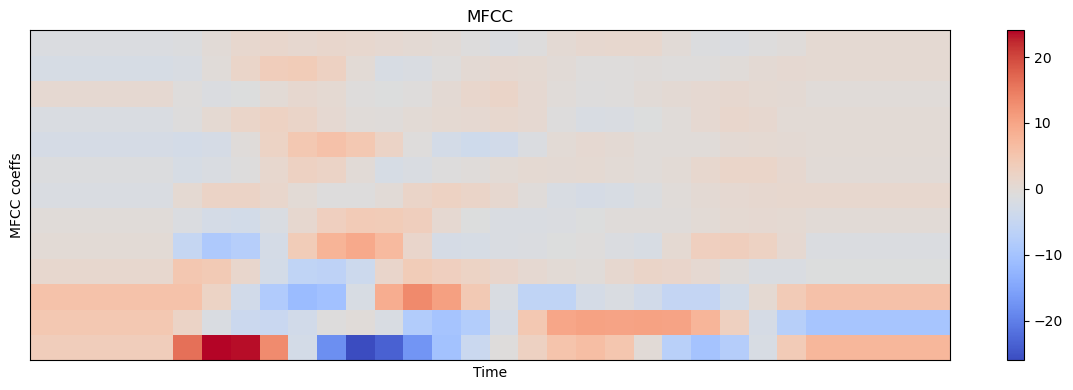

In [8]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel("MFCC coeffs")
plt.xlabel("Time")
plt. title("MFCC")
plt.colorbar()
plt.tight_layout()

In classical, but still state-of-the-art systems, MFCC or similar features are taken as the input to the system instead of spectrograms.

However, in end-to-end (often neural-network based) systems, the most common input features are probably raw spectrograms, or mel power spectrograms. For example MFCC decorrelates features, but NNs deal with correlated features well. Also, if you'll understand mel filters, you may consider their usage sensible.a

It is your decision which to choose!

**DeepL 번역**  
고전적이지만 여전히 최첨단 시스템에서는 스펙트로그램 대신 MFCC 또는 이와 유사한 특징을 시스템 입력으로 사용합니다.

그러나 엔드투엔드(종종 신경망 기반) 시스템에서 가장 일반적인 입력 특징은 아마도 원시 스펙트로그램 또는 멜 파워 스펙트로그램일 것입니다. 예를 들어 MFCC는 특징들을 데코레이션하지만, NN은 상관 관계에 있는 특징들을 잘 처리합니다. 또한 멜 필터를 이해할 수 있다면 멜 필터를 사용하는 것이 합리적이라고 생각할 수 있습니다.

어느 것을 선택할지는 여러분의 결정입니다!

## 1.3. Spectrogram in 3d

By the way, times change, and the tools change. Have you ever seen spectrogram in 3d?

In [9]:
# data = [go.Surface(z=spectrogram.T)]
data = [go.Surface(z=spectrogram.T, colorscale="balance")]  # 원본과 비슷한 색 위해 색 지정
layout = go.Layout(
    title = "spectrogram of \"yes\" in 3d",
    scene = dict(
        # yaxis = dict(title="Frequencies", range=freqs),
        # xaxis = dict(title="time", range=times),
        # range 인자는 [min, max]로 값을 줘야 함.
        # 배열의 값 범위가 넓어 원본과 같게 값 하드코딩
        yaxis = dict(title="Frequencies", range=[0, 160]),
        xaxis = dict(title="time", range=[0, 100]),
        zaxis = dict(title="Log amplitude"),
    ),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

(Don't know how to set axis ranges to proper values yet. I'd also like it to be streched like a classic spectrogram above..)

## 1.4. Silence removal

Let's listen to that file

In [10]:
ipd.Audio(samples, rate=sample_rate)

I consider that some VAD (Voice Activity Detection) will be really useful here. Although the words are short, there is a lot of silence in them. A decent VAD can reduce training size a lot, accelerating training speed significantly. Let's cut a bit of the file from the beginning and from the end. and listen to it again (based on a plot above, we take from 4000 to 13000):

**DeepL 번역**  
여기서 일부 VAD(음성 활동 감지)가 정말 유용할 것 같습니다. 단어는 짧지만 그 안에는 많은 침묵이 있습니다. 적절한 VAD는 훈련 크기를 많이 줄여 훈련 속도를 크게 높일 수 있습니다. 파일의 시작 부분과 끝 부분을 잘라내어 다시 들어보겠습니다(위의 도표에 따르면 4000에서 13000까지 걸립니다):

In [11]:
samples_cut = samples[4000:13000]
ipd.Audio(samples_cut, rate=sample_rate)

We can agree that the entire word can be heard. It is impossible to cut all the files manually and do this basing on the simple plot. But you can use for example webrtcvad package to have a good VAD.

Let's plot it again, together with guessed alignment of 'y' 'e' 's' graphems

**DeepL 번역**  
우리는 전체 단어가 들릴 수 있다는 데 동의 할 수 있습니다. 모든 파일을 수동으로 자르고 간단한 플롯을 기반으로이 작업을 수행하는 것은 불가능합니다. 그러나 예를 들어 webrtcvad 패키지를 사용하면 좋은 VAD를 얻을 수 있습니다.

'y' 'e' 's' 그래프의 추측된 정렬과 함께 다시 플롯해 보겠습니다.

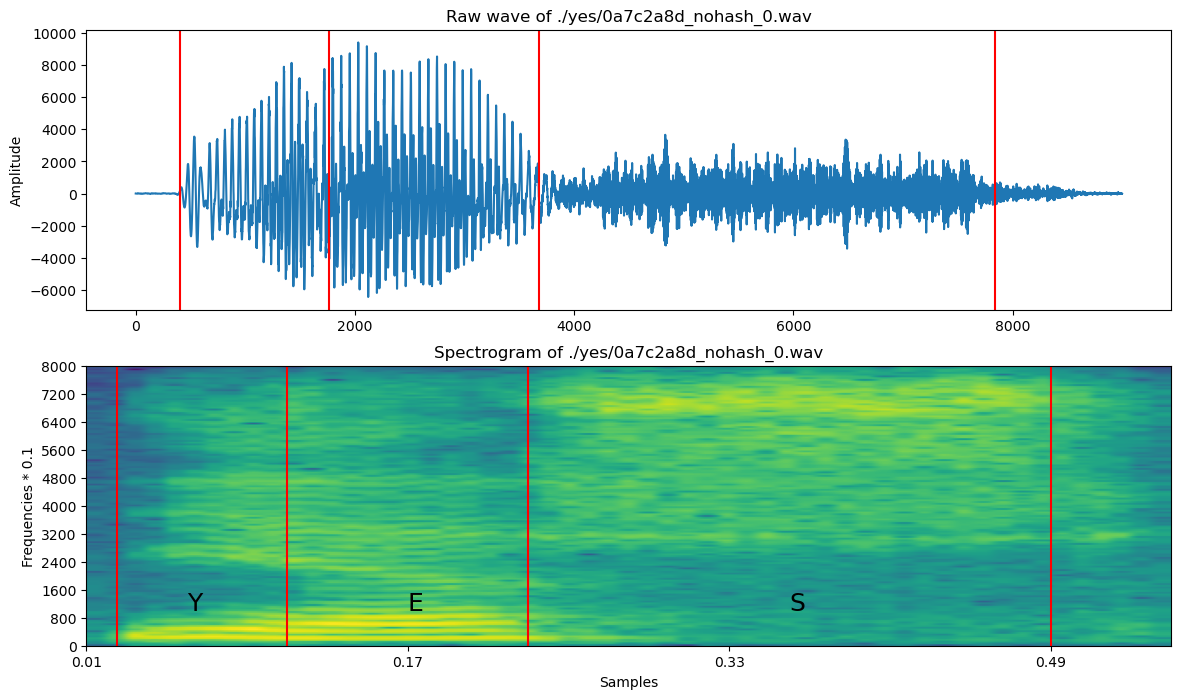

In [12]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title("Raw wave of " + filename)
ax1.set_ylabel("Amplitude")
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title("Spectrogram of " + filename)
ax2.set_ylabel("Frequencies * 0.1")
ax2.set_xlabel("Samples")
ax2.imshow(spectrogram_cut.T, aspect="auto", origin="lower",
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, "Y", fontsize=18)
ax2.text(0.17, 1000, "E", fontsize=18)
ax2.text(0.36, 1000, "S", fontsize=18)

xcords = [0.025, 0.11, 0.23, 0.49]
for xc in xcords:
    ax1.axvline(x=xc*16000, c="r")
    ax2.axvline(x=xc, c="r")

https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration